In [3]:
import mlflow
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
california = fetch_california_housing(as_frame=True)
df = california.frame
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

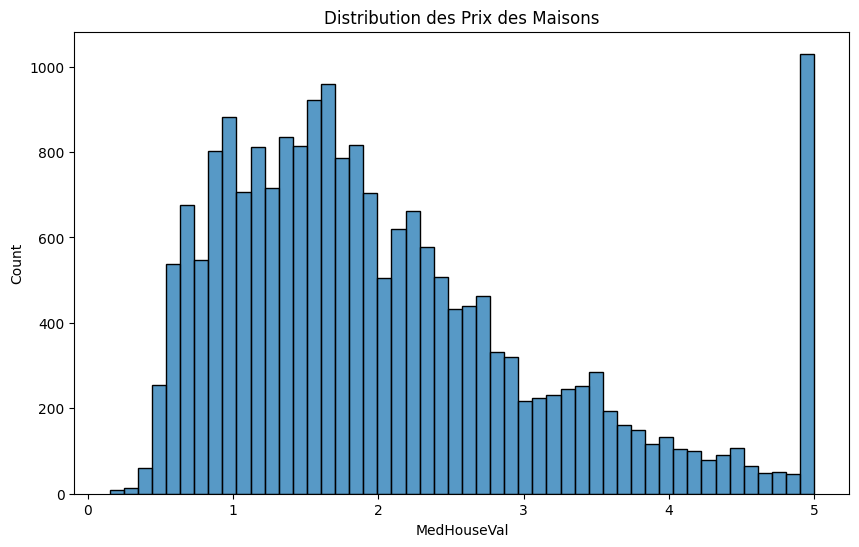

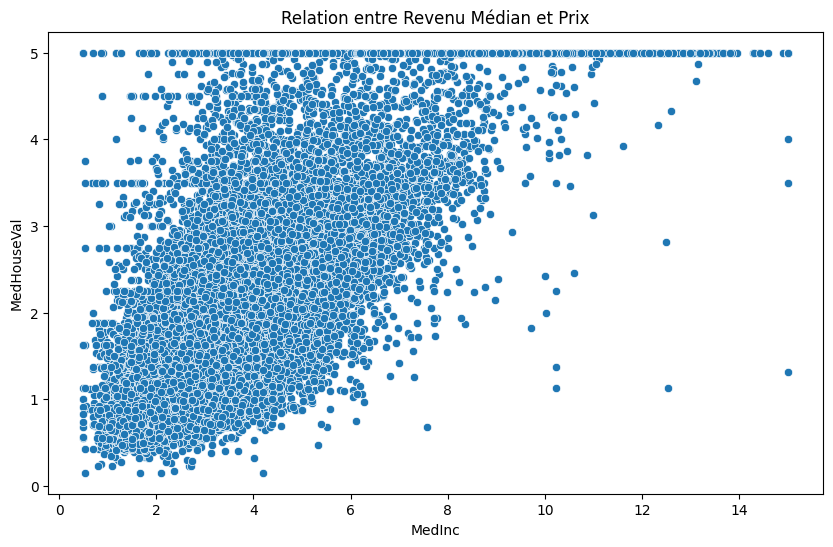

In [9]:
# %%writefile script.py

import mlflow
import pandas as pd
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns


mlflow.set_tracking_uri('http://13.51.140.113:5000/')



# Initialiser l'expérience MLflow
mlflow.set_experiment("california_housing_regression")

with mlflow.start_run(run_name="data_exploration") as run:
    # Charger le jeu de données
    california = fetch_california_housing(as_frame=True)
    df = california.frame
    mlflow.log_param("dataset_shape", df.shape)

    # Analyse descriptive
    desc = df.describe()
    print(desc)
    mlflow.log_text(desc.to_string(), "description.txt")
    mlflow.log_artifact("script.py")

    # Visualisation des distributions (exemples)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['MedHouseVal'], bins=50)
    plt.title('Distribution des Prix des Maisons')
    plt.savefig("histogram_price.png")
    mlflow.log_artifact("histogram_price.png")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="MedInc", y="MedHouseVal", data=df)
    plt.title("Relation entre Revenu Médian et Prix")
    plt.savefig("scatter_income_price.png")
    mlflow.log_artifact("scatter_income_price.png")

    # Log des infos, observations, etc.
    mlflow.log_text("Observation: Le prix des maisons a une distribution non normale...", "data_insights.txt")
    print("Exploration terminée")

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

with mlflow.start_run(run_name="logistic_regression_baseline") as run:
    # Préparation des données pour la classification (exemple: prix > moyenne devient 1, sinon 0)
    df['target_class'] = (df['MedHouseVal'] > df['MedHouseVal'].mean()).astype(int)
    X = df.drop(['MedHouseVal','target_class'], axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Mise à l'échelle des features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entraînement du modèle de régression logistique
    model = LogisticRegression(solver='liblinear', random_state=42)  #solver to prevent warnings
    model.fit(X_train_scaled, y_train)

    # Prédiction et évaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Log des paramètres, métriques et modèle
    mlflow.log_param("solver", "liblinear")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.sklearn.log_model(model, "logistic_model")
    print("Modèle Logistic Regression Entraîné")


2024/12/17 10:15:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Logistic Regression Entraîné
🏃 View run logistic_regression_baseline at: http://13.51.140.113:5000/#/experiments/972577552072586799/runs/327011ac94ca444bbd04c2cc8de720c7
🧪 View experiment at: http://13.51.140.113:5000/#/experiments/972577552072586799


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Prepare Data
X = df.drop(['MedHouseVal','target_class'], axis=1) # using the target_class column for now
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    with mlflow.start_run(run_name=name) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      mse = mean_squared_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("r2", r2)
      mlflow.sklearn.log_model(model, "model")

      print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")


In [18]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

with mlflow.start_run(run_name="random_forest_tuning") as run:
  rf_model = RandomForestRegressor(random_state=42)
  param_dist = {
        "n_estimators": np.arange(50, 200),
        "max_depth": [5, 10, 15, None],
        "min_samples_split": np.arange(2, 10),
        "min_samples_leaf": np.arange(1, 5)
  }
  rf_random = RandomizedSearchCV(rf_model, param_dist, n_iter=2, cv=3, random_state=42, scoring='neg_mean_squared_error')
  rf_random.fit(X_train, y_train)

  best_model = rf_random.best_estimator_
  best_params = rf_random.best_params_
  y_pred = best_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  mlflow.log_params(best_params)
  mlflow.log_metric("mse", mse)
  mlflow.log_metric("r2", r2)
  mlflow.sklearn.log_model(best_model, "best_model")
  print(f"Best Random Forest Model (Tuned): MSE = {mse:.2f}, R2 = {r2:.2f}")